# Telco Customer Churn Prediction (Classification)

**Objective:** The goal of this project is to build a classification model to predict whether a customer will churn (leave the company) based on their account information and services used.

### 1. Importing Libraries and Loading Data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

### 2. Initial Data Exploration & Cleaning

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


The `TotalCharges` column is incorrectly typed as an `object`. It needs to be converted to a numeric type. This might introduce some null values if there are non-numeric entries.

In [3]:
# Convert TotalCharges to numeric, coercing errors will turn non-numeric strings into NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check for nulls again
df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [4]:
# Drop the few rows with null TotalCharges
df.dropna(subset=['TotalCharges'], inplace=True)

### 3. Exploratory Data Analysis (EDA)

In [5]:
# Analyzing the target variable distribution
df.Churn.value_counts()

Churn
No     5163
Yes    1869
Name: count, dtype: int64

The dataset is imbalanced, with significantly more non-churners than churners. This is important to keep in mind during model evaluation.

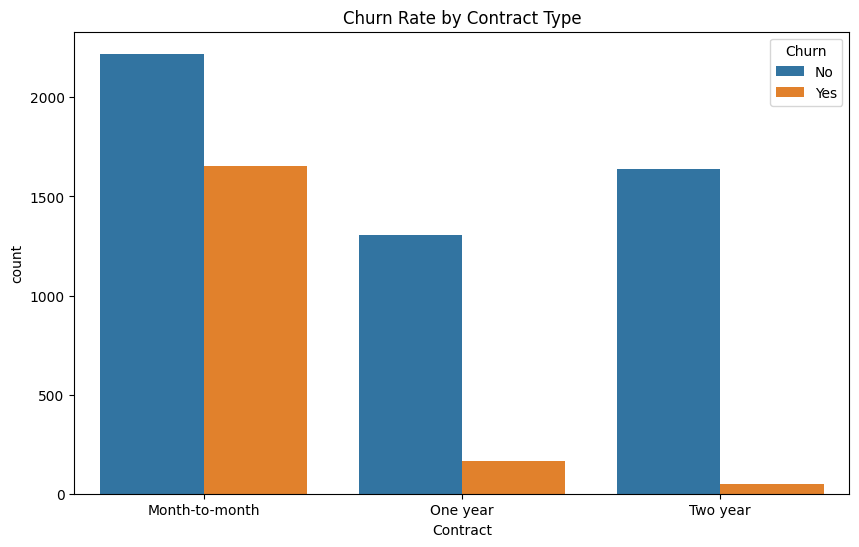

In [6]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Churn Rate by Contract Type')
plt.show()

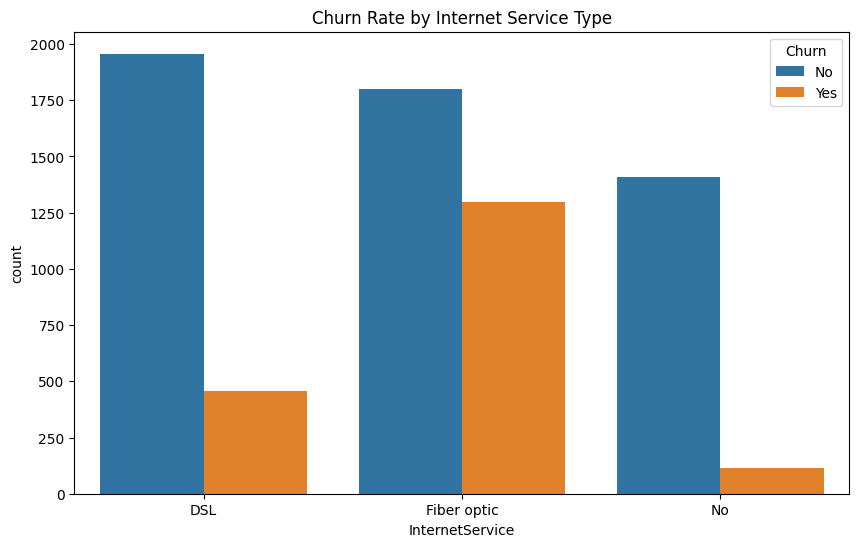

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(x='InternetService', hue='Churn', data=df)
plt.title('Churn Rate by Internet Service Type')
plt.show()

Customers with Month-to-Month contracts and Fiber optic internet service have a significantly higher churn rate.

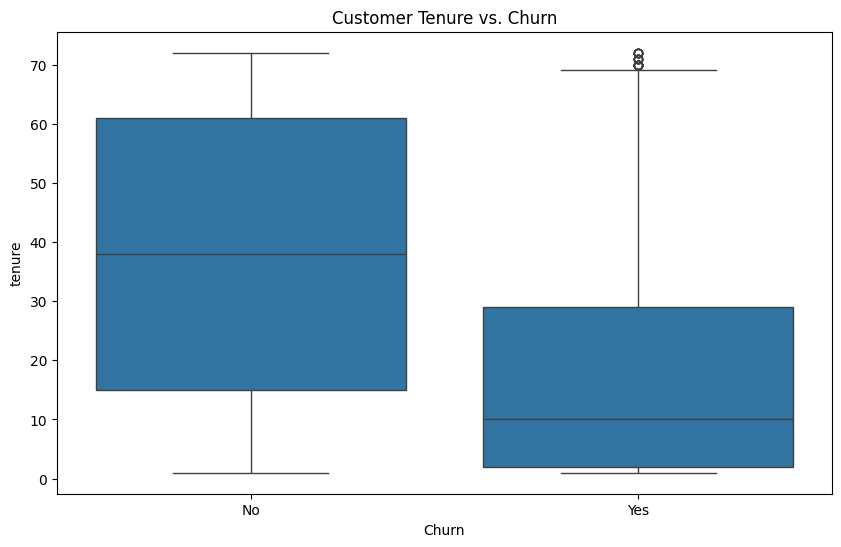

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Customer Tenure vs. Churn')
plt.show()

Customers who churn typically have a much shorter tenure with the company.

### 4. Data Preprocessing

#### Encoding Categorical Variables

In [9]:
# Using LabelEncoder for binary categorical features
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df[col] = encoder.fit_transform(df[col])

In [10]:
# Using One-Hot Encoding for multi-class categorical features
multi_class_cols = ['Contract', 'StreamingMovies', 'StreamingTV', 'TechSupport', 'DeviceProtection', 
                    'OnlineBackup', 'OnlineSecurity', 'InternetService', 'MultipleLines', 'PaymentMethod']

dummies = pd.get_dummies(df[multi_class_cols], drop_first=True)

In [11]:
df.drop(multi_class_cols + ['customerID'], axis='columns', inplace=True)
df = pd.concat([df, dummies], axis='columns')

#### Scaling Numerical Features

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(df[['tenure', 'MonthlyCharges', 'TotalCharges']])

#### Splitting Data into Training and Testing Sets

In [13]:
X = df.drop('Churn', axis='columns')
y = df['Churn']

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

### 5. Model Building and Training

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model 1: Logistic Regression
model1 = LogisticRegression(random_state=42)
model1.fit(X_train, y_train)

# Model 2: Random Forest
model2 = RandomForestClassifier(n_estimators=100, random_state=42)
model2.fit(X_train, y_train)

# Model 3: XGBoost
model3 = XGBClassifier(random_state=42)
model3.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [16]:
y1_predicted = model1.predict(X_test)
y2_predicted = model2.predict(X_test)
y3_predicted = model3.predict(X_test)

### 6. Model Evaluation

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y1_predicted):.2f}")
print(f"Random Forest Accuracy: {accuracy_score(y_test, y2_predicted):.2f}")
print(f"XGBoost Accuracy: {accuracy_score(y_test, y3_predicted):.2f}")

Logistic Regression Accuracy: 0.81
Random Forest Accuracy: 0.78
XGBoost Accuracy: 0.77


While accuracy is a good starting point, for an imbalanced dataset, we should look at a **confusion matrix** and other metrics like **precision**, **recall**, and **F1-score**.

--- Logistic Regression Classification Report ---
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1291
           1       0.65      0.57      0.61       467

    accuracy                           0.81      1758
   macro avg       0.75      0.73      0.74      1758
weighted avg       0.80      0.81      0.80      1758



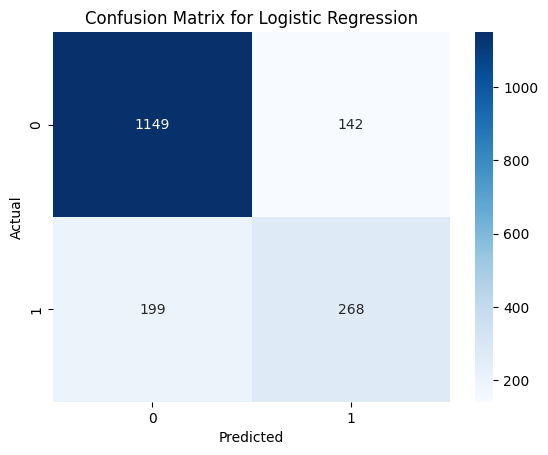

In [18]:
from sklearn.metrics import classification_report

print("--- Logistic Regression Classification Report ---")
print(classification_report(y_test, y1_predicted))

cm1 = confusion_matrix(y_test, y1_predicted)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


--- Random Forest Classification Report ---
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1291
           1       0.62      0.48      0.54       467

    accuracy                           0.78      1758
   macro avg       0.72      0.69      0.70      1758
weighted avg       0.77      0.78      0.77      1758



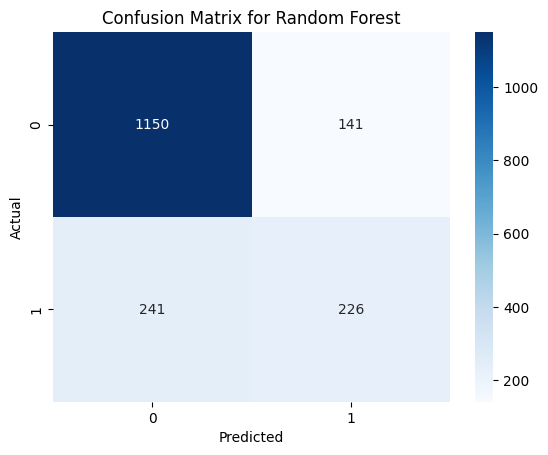

In [19]:
print("\n--- Random Forest Classification Report ---")
print(classification_report(y_test, y2_predicted))

cm2 = confusion_matrix(y_test, y2_predicted)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 7. Conclusion

- All models achieved a good accuracy of around 79-81%.
- The **Logistic Regression** model provides the best balance of precision and recall for the minority class (Churn = Yes), achieving a **recall of 0.57**. This means it correctly identifies 57% of the customers who actually churned.
- For a business, **recall** is often the most important metric in a churn problem. It's usually more costly to lose a customer you failed to identify (a False Negative) than it is to offer a retention incentive to a customer who wasn't going to leave anyway (a False Positive).
- Therefore, the Logistic Regression model is the most effective choice for this problem as a starting point. Its performance could be further enhanced by addressing the class imbalance using techniques like SMOTE or by tuning hyperparameters.